In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
np.__version__

'1.16.2'

In [12]:
# !apt-get install -y libjpeg-8d

# !apt-get install -y libjpeg62-dev

In [13]:
# !pip install jpeg2dct==0.2.3
# !apt-get install -y libjpeg8-dbg

In [14]:
# !ldconfig -v | grep jpeg
# !apt-get install -y libjpeg8
# !ldconfig -p | grep libjpeg
# !ls /usr/lib/x86_64-linux-gnu/libjpeg.so.8*
# !apt install libjpeg-turbo8-dev
# !apt-get remove libjpeg6 & apt-get remove libjpeg8 & apt-get autoremove

In [15]:
from jpeg2dct.numpy import load, loads

In [16]:
import cv2
import glob

In [17]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

from tensorflow.keras import regularizers

import tensorflow as tf
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
file = '/kaggle/input/alaska2-image-steganalysis/Cover/00002.jpg'

# with Reader(file) as r:
#     image = parse_stream(r)

In [ ]:
# img_cov = np.array(image['I'])[0].reshape(512, 512)

# plt.imshow(img_cov, cmap='gray' ,vmax = np.max(img_cov)*0.01,vmin = 0)

In [ ]:
def read_DCT(file):
#     with Reader(file) as r:
#         image = parse_stream(r)
    dct_y, dct_cb, dct_cr = load(file)
    img = np.zeros((512, 512))
    for i in range(dct_y.shape[0]):
        for j in range(dct_y.shape[1]):
            img[i*8:(i+1)*8, j*8:(j+1)*8] += dct_y[i][j].reshape(8, 8)
    return img.reshape(512, 512, 1)

In [ ]:
import numpy as np
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [32]:
stride = (1,1)
penalty = 2e-5
def layer1(input_, filters=16):
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=stride, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(penalty), 
                padding='same', use_bias=True)(input_)
    bn1 = BatchNormalization(momentum=0.9)(c1)
    a1 = Activation(relu)(bn1)
    
    return bn1

def layer2(input_, filters=16):
    l1 = layer1(input_, filters=filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=stride, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(penalty), 
                padding='same', use_bias=True)(l1)  
    bn1 = BatchNormalization(momentum=0.9)(c1)
    bn1 = Activation(relu)(bn1)
    conc = add([input_, bn1])
    
    return conc

def layer3(input_, filters=16):
    l1 = layer1(input_, filters=filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=stride, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(penalty), 
                padding='same', use_bias=True)(l1)
    bn1 = BatchNormalization(momentum=0.9)(c1)
    mp1 = AveragePooling2D(pool_size=(3,3), strides=(2, 2), padding='same')(bn1)
    
    # side stream
    c1_s = Conv2D(filters=filters, kernel_size=(1,1), strides=(2, 2), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(penalty), 
                  padding='same', use_bias=True)(input_)
    bn1_s = BatchNormalization(momentum=0.9)(c1_s)

    conc = add([mp1, bn1_s])
    
    return conc

def layer4(input_, filters=16):
    l1 = layer1(input_, filters=filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=stride, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(penalty), 
                padding='same', use_bias=True)(l1)
    bn1 = BatchNormalization(momentum=0.9)(c1)
    
    g1 = GlobalAveragePooling2D()(bn1)
    
    return g1

In [39]:
def srnet(input_img):
    # Two layers of type 1
    l1_1 = layer1(input_img, filters=64)
    l1_2 = layer1(l1_1, filters=16)
    
#     # Five layers of type 2
    l2_1 = layer2(l1_2, filters=16)
    l2_2 = layer2(l2_1, filters=16)
    l2_3 = layer2(l2_2, filters=16)
    l2_4 = layer2(l2_3, filters=16)
    l2_5 = layer2(l2_4, filters=16)
    
    # four layers of type 3
    l3_1 = layer3(l2_5, filters=16)
    l3_2 = layer3(l3_1, filters=64)
    l3_3 = layer3(l3_2, filters=128)
    l3_4 = layer3(l3_3, filters=256)
    
    l4_1 = layer4(l3_4, filters=512)
    
#     fc1 = Flatten()(l4_1)
#     d1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(2e-4))(l4_1)
#     do1 = Dropout(0.3)(d1)
#     d2 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(2e-4))(d1)
#     do2 = Dropout(0.3)(d2)
    d3 = Dense(2, activation='softmax')(l4_1)
        
    return d3

In [44]:
image_size = (256, 256)
input_img = Input(shape = (*image_size, 3))

sr_ = Model(input_img, srnet(input_img))

In [45]:
sr_.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 256, 256, 64) 256         conv2d_182[0][0]                 
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 256, 256, 16) 9232        batch_normalization_182[0][0]    
____________________________________________________________________________________________

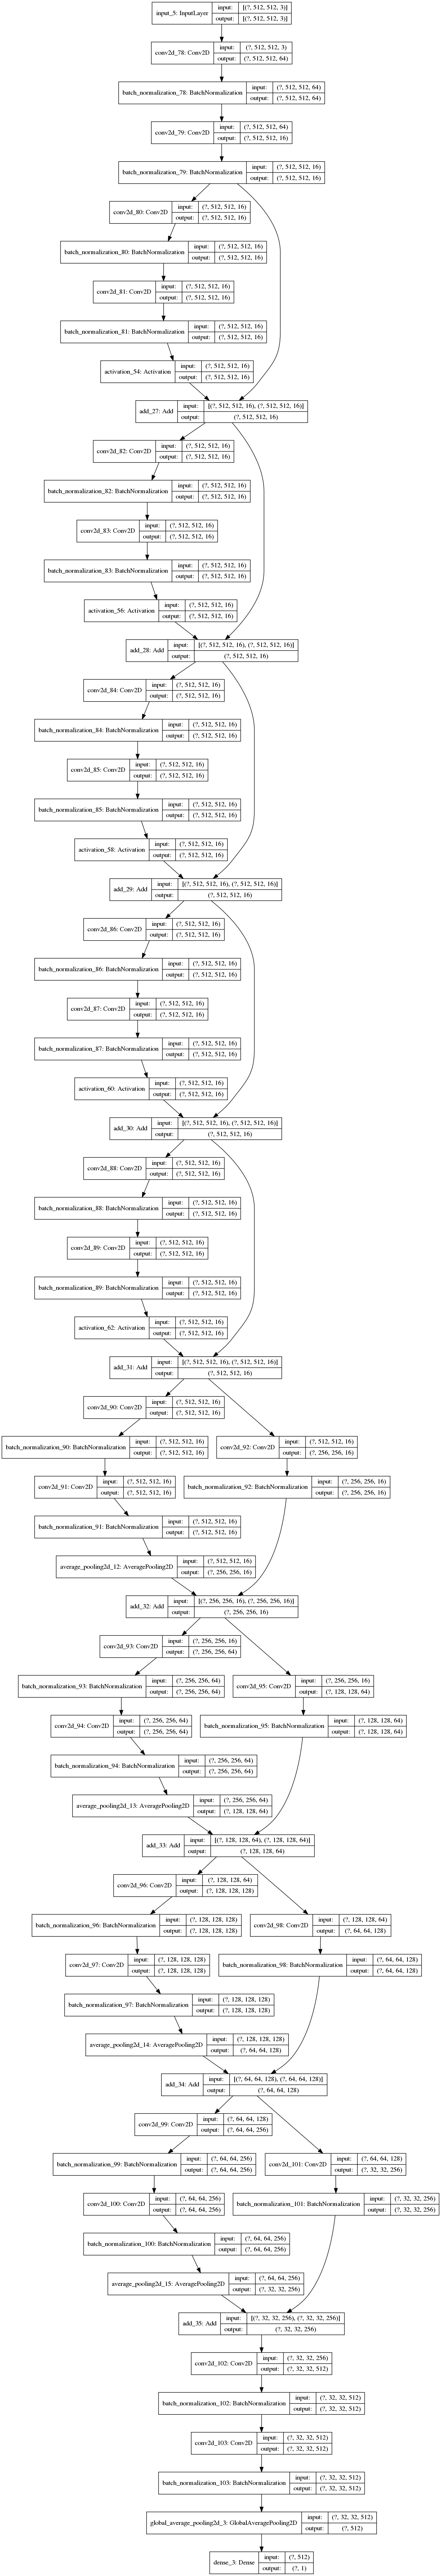

In [36]:
keras.utils.plot_model(sr_,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
input_dir = '../'
limit = 500
cover_imgs = sorted(glob.glob(input_dir+'Cover/*.jpg'))
#random.Random(4).shuffle(cover_imgs)
cover_imgs = cover_imgs[:limit]

# jmipod_imgs = sorted(glob.glob(input_dir+'JMiPOD/*.jpg'))
#random.Random(4).shuffle(jmipod_imgs)
# jmipod_imgs = jmipod_imgs[:limit]

juniward_imgs = sorted(glob.glob(input_dir+'JUNIWARD/*.jpg'))
# #random.Random(4).shuffle(juniward_imgs)
juniward_imgs = juniward_imgs[:limit]

# uerd_imgs = glob.glob(input_dir+'UERD/*.jpg')
# #random.Random(4).shuffle(uerd_imgs)
# uerd_imgs = uerd_imgs[:limit]

In [ ]:
print(cover_imgs[1])
# print(jmipod_imgs[10])
print(juniward_imgs[100].split('/')[-1])
# print(uerd_imgs[0])

In [ ]:
# list_IDs = cover_imgs + jmipod_imgs + juniward_imgs + uerd_imgs
# random.Random(4).shuffle(list_IDs)

till = int(0.8*len(cover_imgs))

train_IDs = []
test_IDs = []

train_IDs = cover_imgs[:till] + juniward_imgs[:till]# + uerd_imgs[:till]
# train_IDs = [i.split('/')[-1] for i in train_IDs]
test_IDs = cover_imgs[till:] + juniward_imgs[till:]# + uerd_imgs[till:]
# test_IDs = [i.split('/')[-1] for i in test_IDs]

In [ ]:
print(cover_imgs[-10])
print(juniward_imgs[-10])

In [ ]:
def get_image_data(image_id, image_size):
    img = cv2.imread(image_id)
    h, w = image_size
    img= img[100:100+h, 100:100+w]
    return img#.reshape(*image_size, 1)

def get_label(image_id):
    if 'Cover' in image_id:
        return 0
    else:
        return 1
#     elif 'JMiPOD' in image_id:
#         return [0,1,0,0]
#     elif 'JUNIWARD' in image_id:
#         return [0,0,1,0]
#     elif 'UERD' in image_id:
#         return [0,0,0,1]

In [ ]:
from skimage.color import rgb2hed

In [ ]:
flag_HSV = cv2.COLOR_BGR2HSV
flag_YUV = cv2.COLOR_BGR2YUV
flag_LAB = cv2.COLOR_BGR2LAB
flag_HED = 'flag_HED'
flag_XYZ = cv2.COLOR_BGR2XYZ
flag_YCR_CB = cv2.COLOR_BGR2YCR_CB

def changeColorSpace(img, flag):
    if flag == 'flag_HED':
        img = rgb2hed(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return img
    else:
        img = cv2.cvtColor(img, flag)
        return img
    
def max_rgb_filter(image):
    # split the image into its BGR components
    (B, G, R) = cv2.split(image)
    # find the maximum pixel intensity values for each
    # (x, y)-coordinate,, then set all pixel values less
    # than M to zero
    M = np.maximum(np.maximum(R, G), B)
    R[R < M] = 0
    G[G < M] = 0
    B[B < M] = 0
    # merge the channels back together and return the image
    return cv2.merge([B, G, R])

def min_rgb_filter(image):
    # split the image into its BGR components
    (B, G, R) = cv2.split(image)
    # find the minimum pixel intensity values for each
    # (x, y)-coordinate,, then set all pixel values greater
    # than M to zero
    M = np.minimum(np.minimum(R, G), B)
    R[R > M] = 0
    G[G > M] = 0
    B[B > M] = 0
    # merge the channels back together and return the image
    return cv2.merge([B, G, R])

In [ ]:
img_1 = read_DCT(train_IDs[2]).reshape(*image_size)
# img_1 = changeColorSpace(img_1, flag_YCR_CB)

img_2 = read_DCT(juniward_imgs[2]).reshape(*image_size)
# img_2 = changeColorSpace(img_2, flag_YCR_CB)

print(img_1.shape)
plt.imshow(img_2 - img_1)#.reshape(*image_size))

In [ ]:
np.min(img_2 - img_1)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, number_of_labels=2):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.number_of_labels = number_of_labels
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        # cv2 recevrses height and width
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim[::-1], self.n_channels))
#         y = np.empty((self.batch_size, *self.dim[::-1]))
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float)
        y = np.empty((self.batch_size))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = read_DCT(ID)#, self.dim)
            X[i,] = img#changeColorSpace(img, flag_YCR_CB)[:, :, 0].reshape(*image_size,1)
            y[i] = get_label(ID)
            
        
        return X, y

In [ ]:
# Parameters
params = {'dim': image_size,
          'batch_size': 1,
          'n_channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(test_IDs, **params)

In [ ]:
X, y = training_generator.__getitem__(15)

In [ ]:
plt.imshow(X[0].reshape((*image_size)))

In [ ]:
y

In [ ]:
# input_img = Input(shape = (*image_size, 3))

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


sr_ = Model(input_img, srnet(input_img))

# sr_.compile(loss=keras.losses.binary_crossentropy, 
#                     metrics=METRICS, optimizer=tf.keras.optimizers.Adamax(learning_rate=5e-3))

In [ ]:
sr_.compile(loss=keras.losses.binary_crossentropy, 
                    metrics=METRICS, optimizer=tf.keras.optimizers.Adamax(learning_rate=5e-2))

#tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07))
#tf.keras.optimizers.Adamax(learning_rate=5e-3))
#tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True)

In [ ]:
sr_model_history = sr_.fit_generator(generator=training_generator, 
                                     validation_data=validation_generator, epochs=20)

In [ ]:
len(sr_.layers)

In [ ]:
start = 75
layer_outputs = [layer.output for layer in sr_.layers[start:start+2]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=sr_.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(X)

In [ ]:
activations[0].shape

In [ ]:
plt.imshow(activations[1][0,:,:,3])

In [ ]:
plt.plot(sr_model_history.history['loss'], label='loss (testing data)')
plt.plot(sr_model_history.history['val_loss'], label='val loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# sr_.save('Alaska_model.h5')

In [ ]:
input_dir = '/kaggle/input/alaska2-image-steganalysis/'
test_imgs = glob.glob(input_dir+'Test/*.jpg')

In [ ]:
len(test_imgs)

In [ ]:
def generateTestData(id_list, dim=image_size, n_channels=3):
    batch_size = len(id_list)
    X = np.empty((batch_size, *dim, n_channels))

    # Generate data
    for i, ID in enumerate(id_list):
        # Store sample
        X[i,] = get_image_data(ID, dim)
    return X

In [ ]:
preds = []

In [ ]:
for i in range(0, 5000, 2):
    X = generateTestData(test_imgs[i:i+2])
    y_pred = sr_.predict(X)
    preds.append([test_imgs[i].split('/')[-1], y_pred[0][1]])
    preds.append([test_imgs[i+1].split('/')[-1], y_pred[1][1]])
    if i % 50 == 0:
        print(i)

In [ ]:
len(preds)

In [ ]:
df = pd.DataFrame(preds, columns=["Id", "Label"])

In [ ]:
df.head()

In [ ]:
df.sort_values(['Id'], inplace=True)

In [ ]:
df.head()

In [ ]:
df.to_csv('submission.csv', index=False)

In [ ]:
len(df)

# SRNet

In [18]:
from tensorflow import keras

from tensorflow.keras.models import *


from tensorflow.keras import layers

In [21]:
def SRNet(_inputs):
    #'Layer1' 
    conv=layers.conv2d(_inputs, num_outputs=64, kernel_size=3)
    actv=tf.nn.relu(layers.batch_norm(conv))
    # Layer2'
    conv=layers.conv2d(actv)
    actv=tf.nn.relu(layers.batch_norm(conv))
    #Layer3'
    conv1=layers.conv2d(actv)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn2=layers.batch_norm(conv2)
    res= tf.add(actv, bn2)
    # Layer4'
    conv1=layers.conv2d(res)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn2=layers.batch_norm(conv2)
    res= tf.add(res, bn2)
    # Layer5
    conv1=layers.conv2d(res)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn=layers.batch_norm(conv2)
    res= tf.add(res, bn)
    # 'Layer6
    conv1=layers.conv2d(res)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn=layers.batch_norm(conv2)
    res= tf.add(res, bn)
    # Layer7'
    conv1=layers.conv2d(res)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn=layers.batch_norm(conv2)
    res= tf.add(res, bn)
    # with tf.variable_scope('Layer8'): 
    convs = layers.conv2d(res, kernel_size=1, stride=2)
    convs = layers.batch_norm(convs)
    conv1=layers.conv2d(res)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1)
    bn=layers.batch_norm(conv2)
    pool = layers.avg_pool2d(bn)
    res= tf.add(convs, pool)
    #             with tf.variable_scope('Layer9'):  
    convs = layers.conv2d(res, num_outputs=64, kernel_size=1, stride=2)
    convs = layers.batch_norm(convs)
    conv1=layers.conv2d(res, num_outputs=64)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1, num_outputs=64)
    bn=layers.batch_norm(conv2)
    pool = layers.avg_pool2d(bn)
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer10'): 
    convs = layers.conv2d(res, num_outputs=128, kernel_size=1, stride=2)
    convs = layers.batch_norm(convs)
    conv1=layers.conv2d(res, num_outputs=128)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1, num_outputs=128)
    bn=layers.batch_norm(conv2)
    pool = layers.avg_pool2d(bn)
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer11'): 
    convs = layers.conv2d(res, num_outputs=256, kernel_size=1, stride=2)
    convs = layers.batch_norm(convs)
    conv1=layers.conv2d(res, num_outputs=256)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1, num_outputs=256)
    bn=layers.batch_norm(conv2)
    pool = layers.avg_pool2d(bn)
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer12'): 
    conv1=layers.conv2d(res, num_outputs=512)
    actv1=tf.nn.relu(layers.batch_norm(conv1))
    conv2=layers.conv2d(actv1, num_outputs=512)
    bn=layers.batch_norm(conv2)
    avgp = tf.reduce_mean(bn, reduction_axis,  keepdims=True )
    
    return avgp

In [22]:
image_size = (512, 512)
input_img = Input(shape = (*image_size, 3))

sr_ = Model(input_img, SRNet(input_img))

AttributeError: module 'tensorflow.keras.layers' has no attribute 'conv2d'

In [48]:
sr_ = tf.keras.models.load_model('SRNet_128_128_3.h5')

In [49]:
sr_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [188]:
img_c = cv2.imread('../Cover/00008.jpg')
img_c = cv2.resize(img_c, (128, 128))/255.

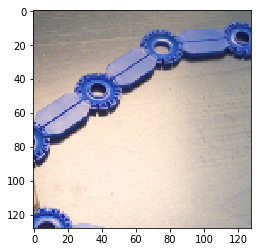

In [189]:
plt.imshow(img_c)

In [190]:
im_c = np.empty((1, 128, 128, 3), dtype=np.float)

im_c[0] = img_c.reshape(128, 128, 3)

In [191]:
layer_output = sr_.get_layer('conv2d_25').output

In [192]:
earlyPredictor = Model(sr_.inputs, layer_output)

In [193]:
pred_c = earlyPredictor.predict(im_c)

In [194]:
pred_c.shape

(1, 8, 8, 512)

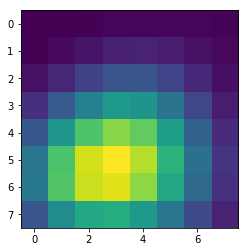

In [195]:
plt.imshow(pred_c[0:,:,:,124].reshape(8, 8))

In [196]:
img_s = cv2.imread('../JMiPOD/00008.jpg')
img_s = cv2.resize(img_s, (128, 128))/255.

im_s = np.empty((1, 128, 128, 3), dtype=np.float)

im_s[0] = img_s.reshape(128, 128, 3)

pred_steg = earlyPredictor.predict(im_s)

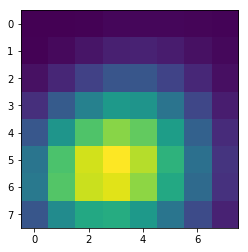

In [198]:
plt.imshow(pred_steg[0:,:,:,124].reshape(8, 8))

W0518 19:04:06.179412 140507866597184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


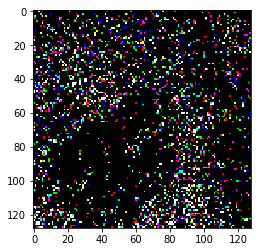

In [199]:
plt.imshow(img_c*255. - img_s*255.)

In [201]:
1e-3

0.001